In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pickle

#sklearn 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score, accuracy_score, classification_report

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb

# READING DATA

## What Does it Take for an NBA player to get into the NBA Hall of Fame?

In [4]:
file_path = '../data/Hall-of-fame-train.csv'

df = pd.read_csv(file_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   league          495 non-null    object
 1   games           495 non-null    int64 
 2   minutes         495 non-null    int64 
 3   pts             495 non-null    int64 
 4   offReb          495 non-null    int64 
 5   defReb          495 non-null    int64 
 6   reb             495 non-null    int64 
 7   asts            495 non-null    int64 
 8   stl             495 non-null    int64 
 9   blk             495 non-null    int64 
 10  turnover        495 non-null    int64 
 11  pf              495 non-null    int64 
 12  fga             495 non-null    int64 
 13  fgm             495 non-null    int64 
 14  fta             495 non-null    int64 
 15  ftm             495 non-null    int64 
 16  tpa             495 non-null    int64 
 17  tpm             495 non-null    int64 
 18  totalSeaso

# DATA EXPLORATION

In [ ]:
df.describe()

There are no missing values
There are players that only played one game and didn't get any minutes on the court, which is interesting

c:\Users\tarun\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tarun\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tarun\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tarun\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

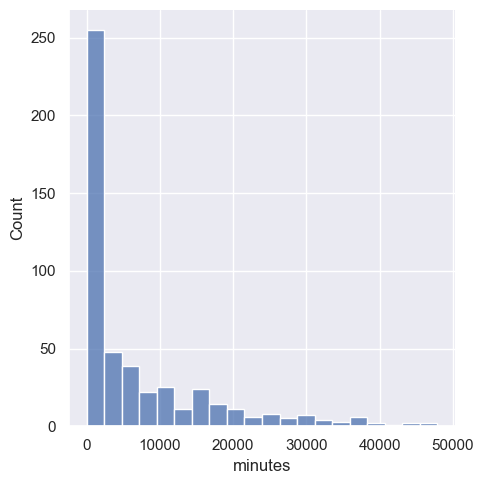

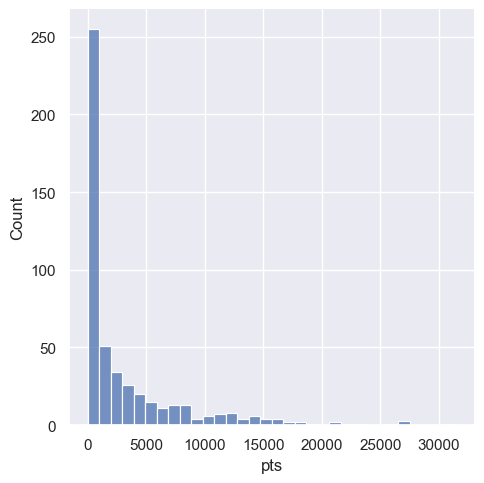

In [28]:
sns.displot(df['minutes'])
sns.displot(df['pts'])

A majority of NBA players don't get minutes on the court and also don't score points.

In [ ]:
# checking the target variable: class

print("Skewness: %.3f" % df['class'].skew())
print("Kurtosis: %.3f" % df['class'].kurt())

print(df['class'].describe())
sns.displot(df['class'])

The target variable is binary as expected. 
A majority of players have a class of 0, meaning they have not entered the NBA Hall of Fame.

In [ ]:
#TODO: It might make sense to adjust the distribution of the class variable to be more evenly distributed (only for training data, not testing)
#TODO: Split the pair plot into two so the individual charts become larger and more clear

In [ ]:
sns.pairplot(df, hue = 'class', height = 2)

## Feature Engineering

In [5]:
"""
Let's create features by dividing features such as points by the number of games the player played. 
The intuition is that capturing the average proportion of points per game would be useful in gauging the ability of a player.
"""

df['Points_Per_Game'] = df['pts'] / df['games']
df['Assists_Per_Game'] = df['asts'] / df['games']
df['Rebounds_Per_Game'] = df['reb'] / df['games']
df['Blocks_Per_Game'] = df['blk'] / df['games']
df['Steals_Per_Game'] = df['stl'] / df['games']
df['Minutes_Per_Game'] = df['minutes'] / df['games']
df['Career_Length_Years'] = df['lastSeason'] - df['firstSeason']

"""
Let's also create Field Goal Percentage and Free Throw Percentage which would be the field goals made divided by the field goals attempted.
"""

df['Field_Goal_Percentage'] = (df['fgm'] / df['fga']).fillna(0)
df['Free_Throw_Percentage'] = (df['ftm'] / df['fta']).fillna(0)


In [6]:
#print(df.columns)
#print(df.head())
#print(df['league'].unique())

# N = National Basketball Association (NBA); A = American Basketball Association (ABA)
# Convert string to integers

df['league'] = np.where(df['league'] == 'N', 1, 0)
df['league'] = df['league'].astype(int)

# Create dummy variables for each unique value in 'Position'
dummies = pd.get_dummies(df['Position'])
df = pd.concat([df, dummies], axis=1)

# Rename column 'C' to 'Center'
df.rename(columns={'C': 'Center Position', 'F': 'Forward Position', 'G': 'Guard Position'}, inplace=True)
df.drop(['Position'], axis=1, inplace=True)

print(df.columns)


Index(['league', 'games', 'minutes', 'pts', 'offReb', 'defReb', 'reb', 'asts',
       'stl', 'blk', 'turnover', 'pf', 'fga', 'fgm', 'fta', 'ftm', 'tpa',
       'tpm', 'totalSeasons', 'firstSeason', 'lastSeason', 'careerEnded',
       'yrsRetired2004', 'class', 'Points_Per_Game', 'Assists_Per_Game',
       'Rebounds_Per_Game', 'Blocks_Per_Game', 'Steals_Per_Game',
       'Minutes_Per_Game', 'Career_Length_Years', 'Field_Goal_Percentage',
       'Free_Throw_Percentage', 'Center Position', 'Forward Position',
       'Guard Position'],
      dtype='object')


In [ ]:
"""
columns_with_missing_values = df.columns[df.isnull().any()].tolist()
print(columns_with_missing_values)
rows_with_missing_values = df[df.isnull().any(axis=1)]
print(rows_with_missing_values)

# Assuming 'df' is your DataFrame and 'Column1' and 'Column2' are the column names
df['Column1'] = df['Column1'].fillna(0)
df['Column2'] = df['Column2'].fillna(0)
"""

# Split Training and Testing Data

In [7]:
#20% for testing
y = df['class']
X = df.drop('class',axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.2, 
                                                    random_state = 123
                                                   )

# Trying various models

## Decision Tree

## Random Forest

In [8]:
# Step 2: Instantiate the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=123)

# Step 3: Fit the model to the training data
rf_model.fit(X_train, y_train)

# Step 4: Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Step 5: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.98989898989899
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        96
           1       0.75      1.00      0.86         3

    accuracy                           0.99        99
   macro avg       0.88      0.99      0.93        99
weighted avg       0.99      0.99      0.99        99



c:\Users\tarun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\tarun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\tarun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\tarun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

In [ ]:
"""
# Maybe figure out soft predictions

y_soft_pred = rf_model.predict_proba(X_test)
#print(y_soft_pred)
soft_predictions = y_soft_pred.tolist()
print(soft_predictions)
"""

## Pickling the model

In [9]:
output_file = 'model_rfc.bin'


In [10]:
with open(output_file, 'wb') as f_out:
    pickle.dump(rf_model, f_out)

In [11]:
with open(output_file, 'rb') as f_in:
    rf_model = pickle.load(f_in)

In [12]:
rf_model

RandomForestClassifier(random_state=123)

In [24]:
#player = X_train.iloc[0]
#row_2d = player.values.reshape(1, -1)
#rf_model.predict_proba(row_2d)[0,1]

player1 = {
    'league': 1,
    'games': 964,
    'minutes': 35875,
    'pts': 14437,
    'offReb': 744,
    'defReb': 1827,
    'reb': 14464,
    'asts': 2575,
    'stl': 125,
    'blk': 553,
    'turnover': 0,
    'pf': 2624,
    'fga': 13105,
    'fgm': 5521,
    'fta': 5089,
    'ftm': 3395,
    'tpa': 0,
    'tpm': 0,
    'totalSeasons': 14,
    'firstSeason': 1963,
    'lastSeason': 1976,
    'careerEnded': 1,
    'yrsRetired2004': 28,
    'Points_Per_Game': 14.976141,
    'Assists_Per_Game': 2.671162,
    'Rebounds_Per_Game': 15.004149,
    'Blocks_Per_Game': 0.573651,
    'Steals_Per_Game': 0.129668,
    'Minutes_Per_Game': 37.21473,
    'Career_Length_Years': 13,
    'Field_Goal_Percentage': 0.42129,
    'Free_Throw_Percentage': 0.667125,
    'Center Position': True,
    'Forward Position': False,
    'Guard Position': False
}

In [25]:
def predict(player):
    player_row_df = pd.DataFrame([player])
    soft_prediction_for_player = rf_model.predict_proba(player_row_df)[0,1]
    return soft_prediction_for_player

prediction = predict(player1)
print(f'\nProbability of NBA player entering the Hall of Fame:\n{prediction}')


Probability of NBA player entering the Hall of Fame:
0.94


c:\Users\tarun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\tarun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\tarun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
